In [45]:
import zipfile
import numpy as np
import re
import matplotlib.pyplot as plt
import difflib
from IPython.display import Markdown, display
def printmd(string, add=""):
    display(Markdown(string + " " + str(add)))

In [46]:
# classification task
signal = "m_a"

In [47]:
# path to labeled dataset
path = signal + "/"

In [48]:
# path to unlabeled data
path_unlabeled = "/"

The idea is to build embeddings of the positive and unlabeled data, so that the similarity between both sets can be compared to infer labels for the unlabeled data. If a unlabeled post is near to the centroid of the positive set, one could assume that it may be positive. If it is far away, it is most likely not positive.

# Getting the data

In [49]:
def get_zipped_dataset(name, labels=False, titles=True, exclude=".json"):
    def get_dataset_class(filename):
        splittet_name = filename.split(".")
        if len(splittet_name) > 1 and splittet_name[1].replace("U", "") == str(1):
            return 1
        else: return 0

    dataset, dataset_titles, filenames = [], [], []
    dataset_pos, dataset_neg, dataset_pos_titles, dataset_neg_titles = [], [], [], []

    with zipfile.ZipFile(path + "data.zip") as z:
        for filename in z.namelist():
            if name in filename and ".txt" in filename and not exclude in filename:
                with z.open(filename) as f:
                    # getting whole text
                    full_text = f.read().decode('utf-8')
                    # getting only titles
                    title = re.search('xxtitle (.*) xxbodytext', full_text).group(1)
                    
                    filenames.append(filename)
                    
                    if labels:
                        if get_dataset_class(filename):
                            dataset_pos.append(full_text)
                            dataset_pos_titles.append(title)
                        else:
                            dataset_neg.append(full_text)
                            dataset_neg_titles.append(title)
                    else:
                        dataset.append(full_text)
                        dataset_titles.append(title)
    if labels:
        return dataset_pos, dataset_pos_titles, dataset_neg, dataset_neg_titles
    else:
        return dataset, dataset_titles, filenames
    

unlabeled_data, unlabeled_data_titles, unlabeled_filenames = get_zipped_dataset("randomsig_wt/", exclude="small")

#test_data, test_data_titles, test_filenames = get_zipped_dataset("test/")
#unlabeled_data.extend(test_data)
#unlabeled_data_titles.extend(test_data_titles)

positive_data, positive_data_titles, negative_data, negative_data_titles = get_zipped_dataset("train", labels=True)

                
print("Size of labeled data:", len(positive_data) + len(negative_data))
print("Size of positive data:", len(positive_data))
print("Size of negative data:", len(negative_data))
#print("Size of unlabeled data:", len(unlabeled_data))

Size of labeled data: 1558
Size of positive data: 351
Size of negative data: 1207


In [7]:
def get_zipped_dataset(name, labels=False, titles=True, exclude=".json"):
    def get_dataset_class(filename):
        splittet_name = filename.split(".")
        if len(splittet_name) > 1 and splittet_name[1].replace("U", "") == str(1):
            return 1
        else: return 0

    dataset, dataset_titles, filenames = [], [], []
    dataset_pos, dataset_neg, dataset_pos_titles, dataset_neg_titles = [], [], [], []

    with zipfile.ZipFile(path_unlabeled + "corona_1.zip") as z:
        for filename in z.namelist():
            if name in filename and ".txt" in filename and not exclude in filename:
                with z.open(filename) as f:
                    # getting whole text
                    full_text = f.read().decode('utf-8')
                    # getting only titles
                    title = re.search('xxtitle (.*) xxbodytext', full_text).group(1)
                    
                    filenames.append(filename)
                    
                    if labels:
                        if get_dataset_class(filename):
                            dataset_pos.append(full_text)
                            dataset_pos_titles.append(title)
                        else:
                            dataset_neg.append(full_text)
                            dataset_neg_titles.append(title)
                    else:
                        dataset.append(full_text)
                        dataset_titles.append(title)
    if labels:
        return dataset_pos, dataset_pos_titles, dataset_neg, dataset_neg_titles
    else:
        return dataset, dataset_titles, filenames
    


unlabeled_data, unlabeled_data_titles, unlabeled_filenames = get_zipped_dataset("corona_1/")

                
#print("Size of labeled data:", len(positive_data) + len(negative_data))
#print("Size of positive data:", len(positive_data))
#print("Size of negative data:", len(negative_data))
print("Size of unlabeled data:", len(unlabeled_data))

Size of unlabeled data: 378038


In [ ]:
unlabeled_data_titles[0]

In [ ]:
unlabeled_data[0]

# Embedding Creation

In [52]:
from sentence_transformers import SentenceTransformer, models

In [53]:
model = SentenceTransformer('roberta-large-nli-stsb-mean-tokens')

In [54]:
positive_embeddings = model.encode(np.array(positive_data))

In [55]:
unlabeled_embeddings = model.encode(np.array(unlabeled_data))

In [56]:
len(unlabeled_embeddings)

77500

Sanity Check:

In [57]:
unlabeled_embeddings[0]

array([-0.6918019 ,  1.5370989 , -0.9713264 , ...,  0.8122888 ,
        0.05864151, -0.08270334], dtype=float32)

# Getting nearest Embeddings

In [58]:
def get_centroid(embeddings):
    embedding_sum = np.sum(embeddings, axis=0)
    return np.divide(embedding_sum, len(embeddings[0]))

positive_centroid = get_centroid(positive_embeddings)
print(positive_centroid)

[ 0.08644086  0.37375736 -0.0369549  ...  0.11566956 -0.2464187
 -0.17583564]


Remember: cosine similarity is 1 if the vectors have the same angle (same similarity) and 0 if the vectors are unsimilar
 

**[Labeled Data]** The vector that is **least similar** to the other vectors has a similarity score of 0.334746

**[Labeled Data]** The article title of it is: Saputo misses expectations as second-quarter profit falls despite higher revenues

**[Labeled Data]** Boxplot: Distances of the positive set to the positive centroid 

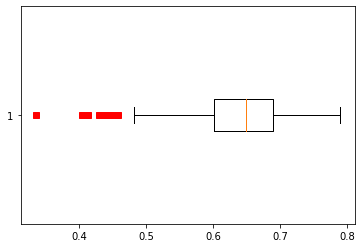

<br>**[Unlabeled Data]** The vector that is **most similar** to the other vectors has a similarity score of 0.8104349

**[Unlabeled Data]** The article title of it is: Federal regulators approve UQM merger with Danfoss

**[Unlabeled Data]** The vector that is **least similar** to the other vectors has a similarity score of -0.045669075

**[Unlabeled Data]** The article title of it is: Sudan shuts schools as pupils’ killing sparks outrage

**[Unlabeled Data]** Boxplot: Distances of the unlabeled set to the positive centroid 

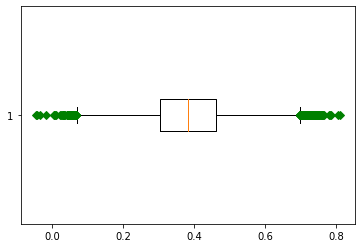

In [59]:
def get_distances(embeddings, centroid, cosine=True):
    def cosine_similarity(a,b):
        return np.dot(a,b)/(np.linalg.norm(a) * np.linalg.norm(b))
    
    if cosine:
        return [cosine_similarity(embedding, centroid) for embedding in embeddings]
    else:
        return - [np.linalg.norm(centroid-embedding, 2) for embedding in embeddings]
    
unlabeled_distances = get_distances(unlabeled_embeddings, positive_centroid)
positive_distances = get_distances(positive_embeddings, positive_centroid)

printmd("Remember: cosine similarity is 1 if the vectors have the same angle (same similarity) and 0 if the vectors are unsimilar\n")

printmd("**[Labeled Data]** The vector that is **least similar** to the other vectors has a similarity score of", np.min(positive_distances))
printmd("**[Labeled Data]** The article title of it is:", positive_data_titles[np.argmin(positive_distances)])
printmd("**[Labeled Data]** Boxplot: Distances of the positive set to the positive centroid")
fig, ax = plt.subplots()
ax.boxplot(positive_distances, 0, 'rs', 0)
plt.show()

printmd("<br>**[Unlabeled Data]** The vector that is **most similar** to the other vectors has a similarity score of", np.max(unlabeled_distances))
printmd("**[Unlabeled Data]** The article title of it is:", unlabeled_data_titles[np.argmax(unlabeled_distances)])

printmd("**[Unlabeled Data]** The vector that is **least similar** to the other vectors has a similarity score of", np.min(unlabeled_distances))
printmd("**[Unlabeled Data]** The article title of it is:", unlabeled_data_titles[np.argmin(unlabeled_distances)])

printmd("**[Unlabeled Data]** Boxplot: Distances of the unlabeled set to the positive centroid")
fig, ax = plt.subplots()
ax.boxplot(unlabeled_distances, 0, 'gD', 0)
plt.show()

In [60]:
def get_k_nearest_indices(distances, k, inverse=False):
    distances = np.array(distances)
    if not inverse:
        return np.argsort(distances)[::-1][:k]
    else:
        return np.argsort(distances)[:k]

def get_nearest_indices_threshold(distances, threshold, inverse=False):
    if not inverse:
        distances = np.array(distances)
        threshold_count = len(list(filter(lambda x: x > threshold, distances)))
        return np.argsort(distances)[::-1][:threshold_count]
    else:
        distances = np.array(distances)
        threshold_count = len(list(filter(lambda x: x < threshold, distances)))
        return np.argsort(distances)[:threshold_count]
    
    
index_of_nearest = get_k_nearest_indices(unlabeled_distances, 2)
print("Nearest vector of the unlabeled data to the centroid (idx):", index_of_nearest)
print("The article title of it is:", unlabeled_data_titles[index_of_nearest[0]])

Nearest vector of the unlabeled data to the centroid (idx): [19644 70607]
The article title of it is: Federal regulators approve UQM merger with Danfoss


In [61]:
#index_of_nearest_dataset = get_k_nearest_indices(unlabeled_distances, 1000)
upper_quantile = np.quantile(positive_distances, 0.95)
index_of_nearest_dataset = get_nearest_indices_threshold(unlabeled_distances, upper_quantile)

#index_of_distant_dataset = get_k_nearest_indices(unlabeled_distances, 5000, True)
lower_quantile = np.quantile(positive_distances, 0.10)
index_of_distant_dataset = get_nearest_indices_threshold(unlabeled_distances, lower_quantile, True)
print(len(index_of_distant_dataset))

71163


In [62]:
new_positive_dataset = [unlabeled_data[index] for index in index_of_nearest_dataset]
new_positive_dataset_titles = [unlabeled_data_titles[index] for index in index_of_nearest_dataset]
new_positive_filenames = [unlabeled_filenames[index] for index in index_of_nearest_dataset][:200]
new_negative_dataset = [unlabeled_data[index] for index in index_of_distant_dataset]
new_negative_dataset = np.random.choice(np.array(new_negative_dataset), 1000)

In [63]:
printmd("The new positive dataset consists of " + str(len(new_positive_dataset)) + " documents")
printmd("The new negative dataset consists of " + str(len(new_negative_dataset)) + " documents")

The new positive dataset consists of 50 documents 

The new negative dataset consists of 1000 documents 

In [64]:
new_positive_dataset[-1]

'xxtitle Funso Ojo and how Aberdeen beat Hibs in epic transfer tussle for midfielder xxbodytext Both clubs had a £125,000 fee accepted by the English side but the Dons managed to convince the 27-year-old to move to Pittodrie.\r\n\r\nAberdeen stepped in with an improved contract and the lure of European football to beat Hibs to the signing of Funso Ojo last night.\r\n\r\nBoth clubs had agreed a £125,000 fee with Scunthorpe United and were given permission to hold talks with the Belgian midfielder, above.\r\n\r\nThe 27-year-old met with Hibs and Paul Heckingbottom on Wednesday but Derek McInnes beat them to the punch yesterday with a convincing sales pitch, including the lure of Europa League football and an enhanced financial package, to get him to Pittodrie.\r\n\r\nOjo’s deal is set to be confirmed within the next 24 hours.\r\n\r\nMcInnes turned his attentions to him after he hit a brick wall trying to bring Dylan McGeouch in from Sunderland for the Europa League campaign.\r\n\r\nThe R

In [20]:
new_positive_dataset_titles[0] in test_data_titles

False

In [21]:
file = open(path + "augmented_top_200.txt", "w")
for filename in new_positive_filenames:
    file.write(filename.replace("randomsig_wt/", "").replace(".txt", ""))
    file.write("\n")

file.close()

new_positive_filenames[155]

'randomsig_wt/c7ce30be-b4dc-480a-8999-5097ccf3d2e8.txt'

# Saving the new datasets

In [39]:
for index, text in enumerate(new_positive_dataset):
    file = open(path + "data/semi_supervised_pos/" + str(index) + "." + "1.txt", "w")
    file.write(text)
    file.close()
    
#for index, text in enumerate(new_negative_dataset):
#    file = open(path + "data/semi_supervised_neg/" + str(index) + "." + "0.txt", "w")
#    file.write(text)
#    file.close()